<a href="https://colab.research.google.com/github/ImagingDataCommons/Cloud-Resources-Workflows/blob/dev/Notebooks/Totalsegmentator/downloadDicomAndConvertNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook can download CT data from Imaging Data Commons and convert to NIfTI with dcm2niix**

DICOM files are downloaded from IDC and converted to NIFTI files with dcm2niix. Whenever there are multiple NIFTI files generated for a series, such series are removed from final output. A CSV file is created with a list of such series.

Please cite:

Li X, Morgan PS, Ashburner J, Smith J, Rorden C. (2016) The first step for neuroimaging data analysis: DICOM to NIfTI conversion. J Neurosci Methods. 264:47-56.

Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S., Aerts, H. J. W. L., Homeyer, A., Lewis, R., Akbarzadeh, A., Bontempi, D., Clifford, W., Herrmann, M. D., Höfener, H., Octaviano, I., Osborne, C., Paquette, S., Petts, J., Punzo, D., Reyes, M., Schacherer, D. P., … Kikinis, R. (2021). NCI Imaging Data Commons. Cancer research, 81(16), 4188–4193. https://doi.org/10.1158/0008-5472.CAN-21-0950



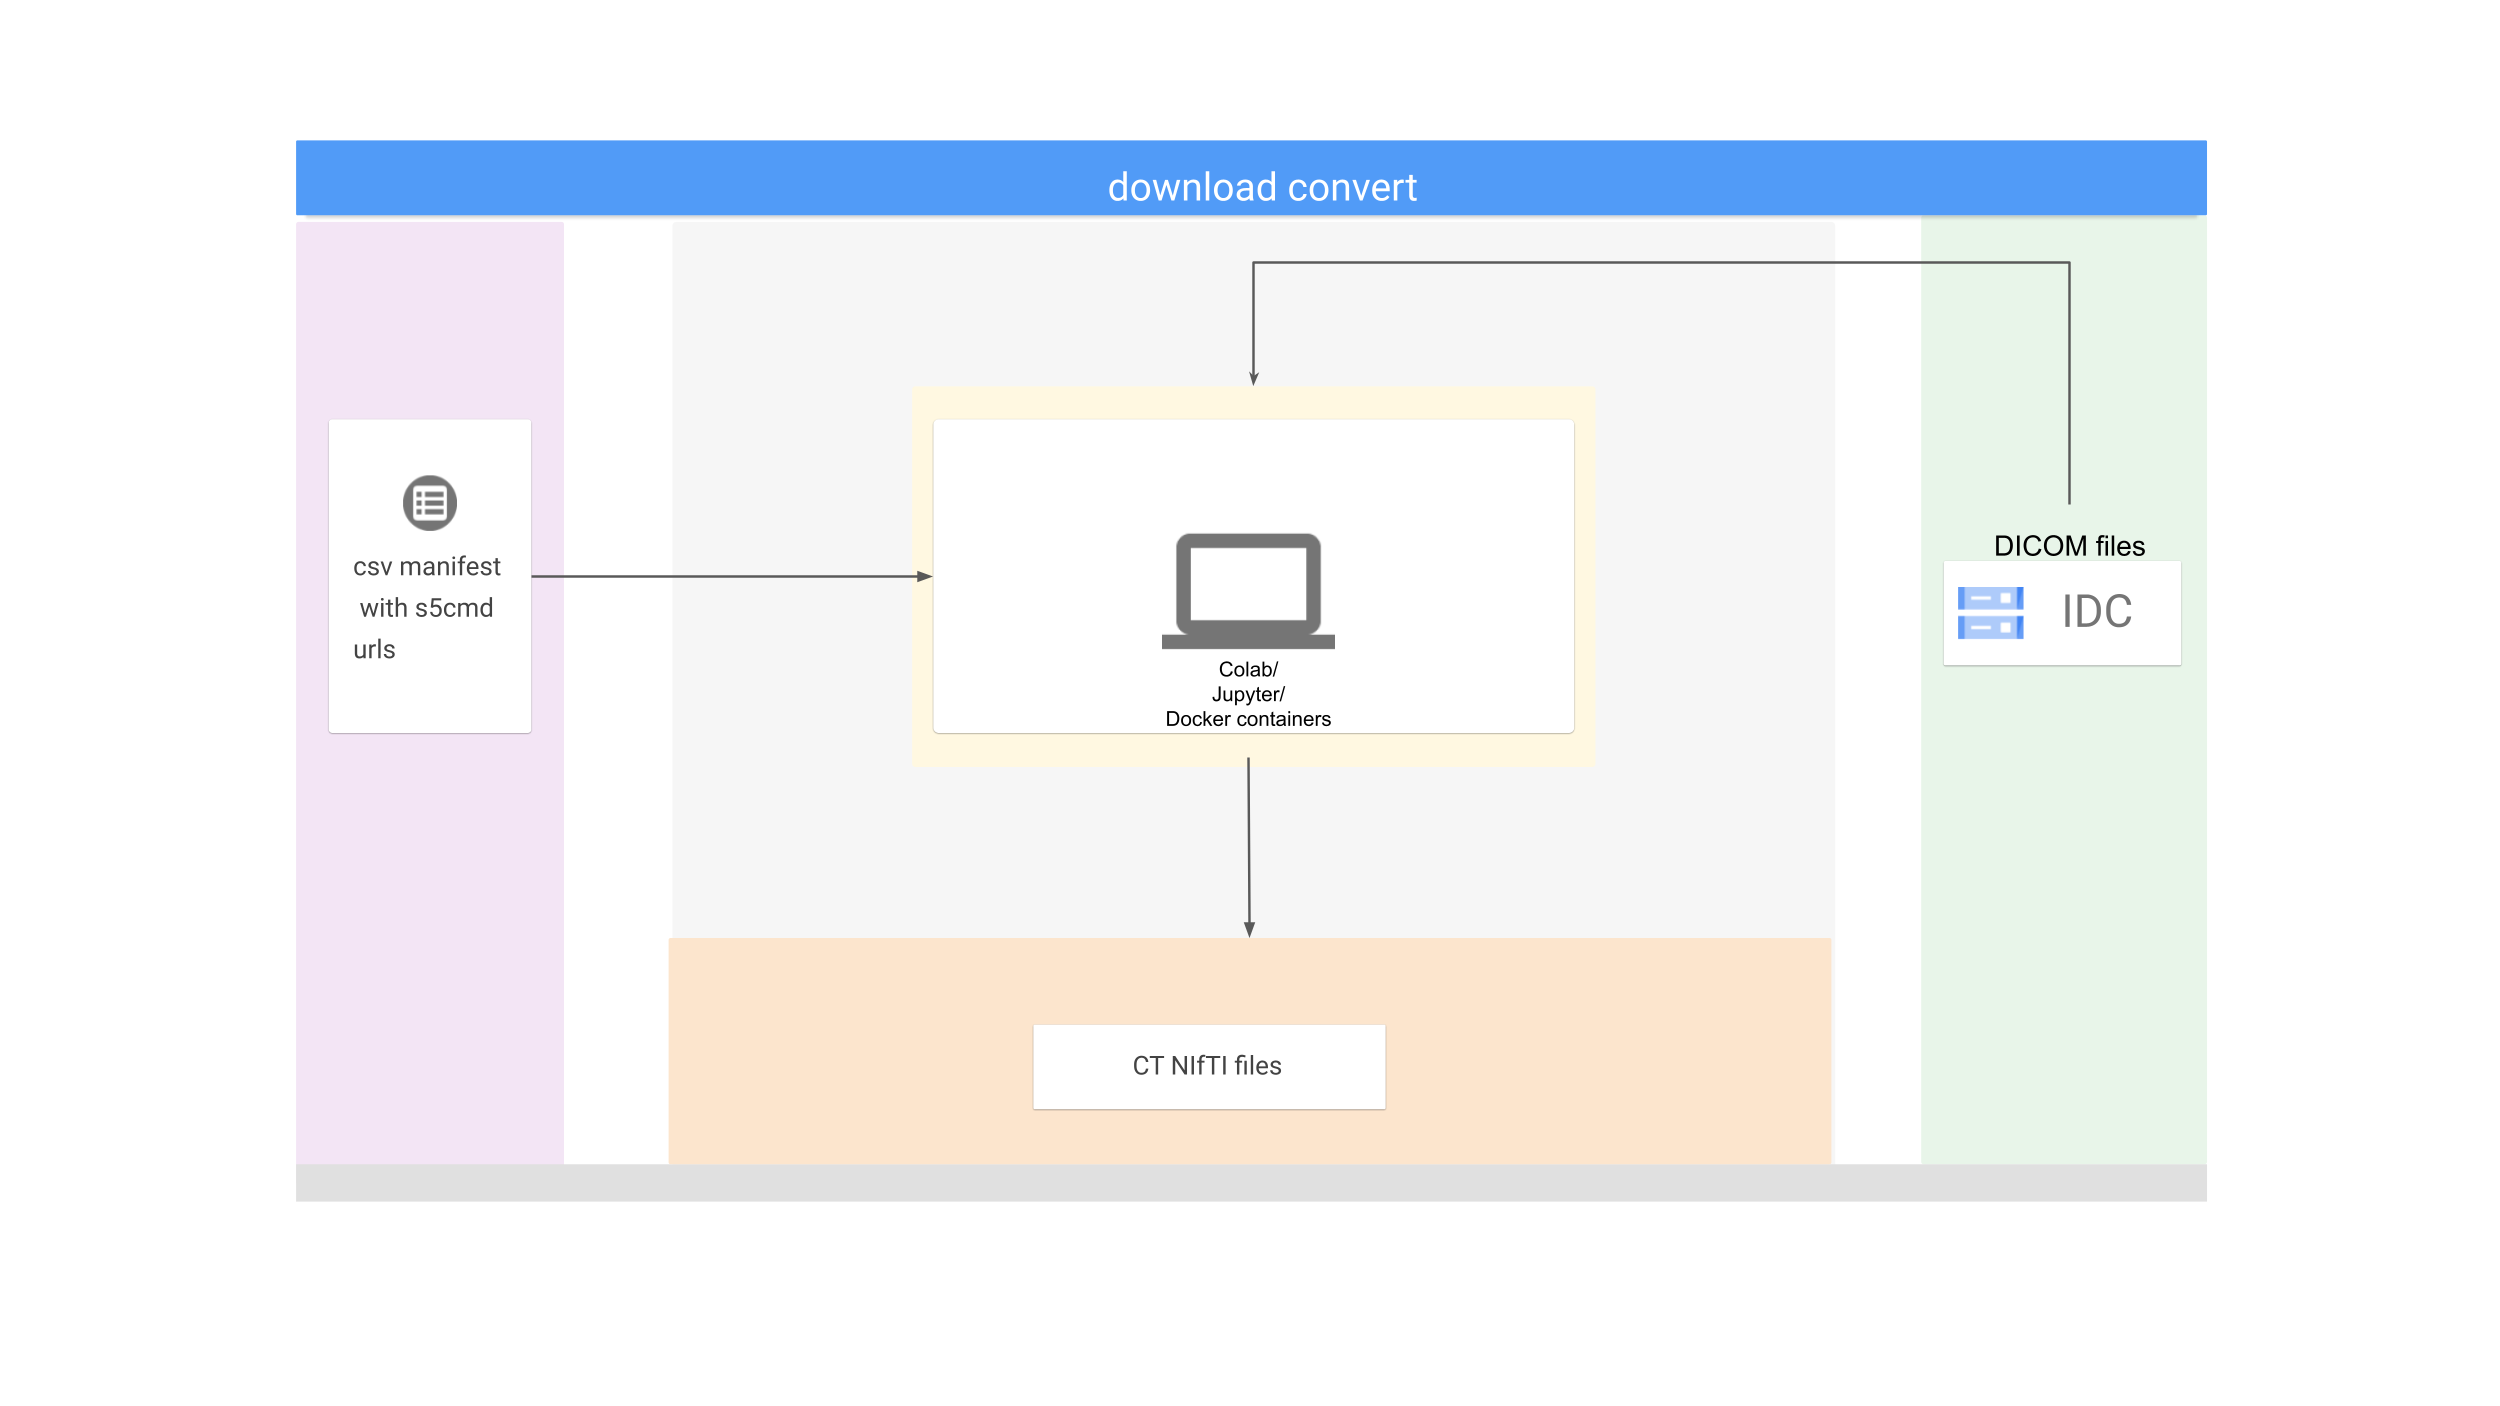

##**Ways to utilize this notebook**


*   **Colab**
*   **Jupyter Notebook/Lab**
*   **DockerContainer/Terra/SB-CGC**


####**Colab/Jupyter Notebook/Lab**
*  This notebook was initally developed and tested on Colab, and a working version is saved on github
*  To run this notebook with Colab, Click 'Open In Colab' icon on top left 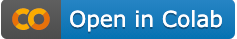
*Uncomment all the cells under "Installing Packages"
*Provide the path to csv manifest containing SeriesInstanceUID and s5cmd download urls (specific to gcp buckets) under "Parameters for Papermill"
* A sample manifest is provided for convenience can be downloaded by uncommenting and running the cells in "For local testing"
* The CSV manifest expects a SeriesInstanceUID and s5cmd url (which contains the destination directory, here it's set to 'idc_data') to download the entire series. The manifest may contain any other metadata if needed.
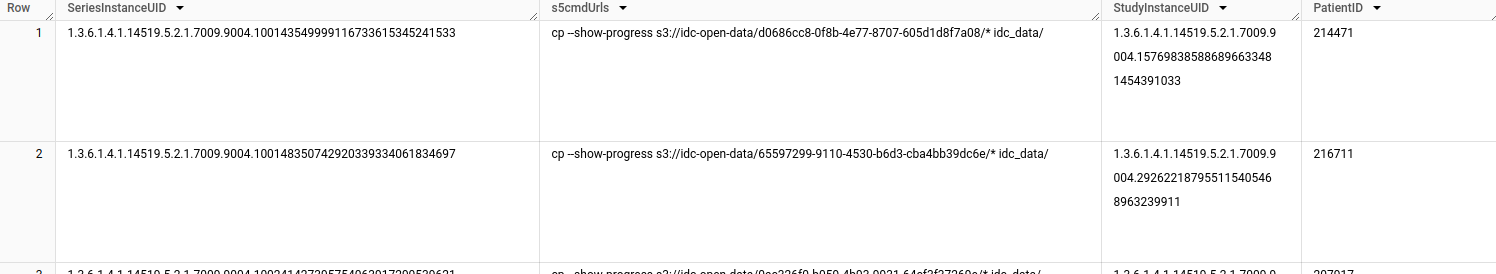
* Run each cell to install the packages and to download the data from IDC, convert to NIfTI saved in lz4 compressed format


####**Docker**
* This notebook is saved by default in a way that's amenable to be used on Terra/SB-CGC platforms using Docker
* Running this notebook in a docker container ensures reproduciblity, as we lock the run environment beginning from the base docker image to apt packages and pip packages in the docker image

* Docker images can be found @ https://hub.docker.com/repository/docker/imagingdatacommons/download_convert/tags
* The link to dockerfile along with git commit hash used for building the docker image can be found in one of the layers called 'LABEL' 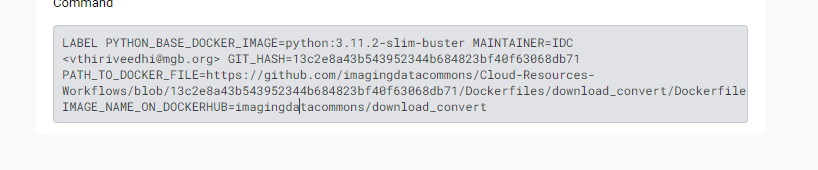
* We use a python package called Papermill, that can run the notebook with out having to convert it to python script. This allows us maintain one copy of code instead of two.
* To use papermill, download this notebook and tag the cell under 'Parameters for Papermill" as parameters using jupyternotebook or jupyterlab as instructed @ https://papermill.readthedocs.io/en/latest/usage-parameterize.html#designate-parameters-for-a-cell
* A sample papermill command is
<pre>
papermill -p csvFilePath path_to_csv_manifest.csv downloadDicomAndConvertNotebook.ipynb outputdownloadDicomAndConvertNotebook.ipynb
</pre>




###**Installing Packages**

In [1]:
# #Use %%capture to hide the stdout from installing packages
# # %%capture

# #Install apt packages
# !sudo apt-get update \
#   && apt-get install -y --no-install-recommends \
#     dcm2niix\
#     lz4\
#     pigz\
#     wget\
#     zip\
#   && rm -rf /var/lib/apt/lists/*

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [515 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.0 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [998 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,137 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.

In [2]:
# #Use %%capture to hide the stdout from installing packages
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.2.2/s5cmd_2.2.2_Linux-64bit.tar.gz"\
#   && tar -xvzf "s5cmd_2.2.2_Linux-64bit.tar.gz"\
#   && rm "s5cmd_2.2.2_Linux-64bit.tar.gz"\
#   && mv s5cmd /usr/local/bin/s5cmd

###**Importing Packages**

In [3]:
import os
import csv
import sys
import time
import pandas as pd
from pathlib import Path
import shutil
import glob
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import matplotlib.pyplot as plt
import subprocess
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Tue Sep 26 14:32:51 2023

Current directory :/content
Python version    : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


###**Parameters for papermill**

In [4]:
csvFilePath='batch_1.csv'

###**For local testing**

In [5]:
# !wget https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
# csvFilePath = glob.glob('*.csv')[0]

--2023-09-26 14:32:51--  https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/notebooks/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5778 (5.6K) [text/plain]
Saving to: ‘batch_1.csv’

batch_1.csv         100%[===================>]   5.64K  --.-KB/s    in 0s      

2023-09-26 14:32:51 (39.3 MB/s) - ‘batch_1.csv’ saved [5778/5778]



###**Reading CSV File containing s5cmd Urls**

In [6]:
start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 0.014051675796508789  seconds


In [7]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()

###**Environment Variable**

In [8]:
converterType='dcm2niix'

###**Defining Functions**

In [9]:
#Creating Directories
try:
  shutil.rmtree(converterType)
except OSError:
  pass
os.mkdir(converterType)

In [10]:
def download_dicom_data(series_id: str) -> None:
  """
  Download raw DICOM data into "idc_data" folder.

  Args:
  series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
  """

  # Attempt to remove the directory for the series if it exists
  try:
    shutil.rmtree(f'idc_data/{series_id}')
  except OSError:
    pass

  # Access the global dataframe variable
  global cohort_df

  # Get the series data from the dataframe
  gs_file_path = "s5cmd_manifest.txt"
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]

  # Write the URLs to a file
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)

  # Remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt

  # Start a timer for the download
  start_time = time.time()
  print("Copying files from IDC buckets..")

  # Download the files and suppress output
  !s5cmd --no-sign-request --endpoint-url https://s3.amazonaws.com run s5cmd_manifest.txt
  #>> /dev/null

  # Calculate and print elapsed time
  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)


In [11]:
def convert_dicom_to_nifti(series_id: str) -> None:
  """
  Converts a DICOM series to a NIfTI file.

  Args:
    series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
  """

  # Determine which converter to use based on the converterType variable
  converter = "dcm2niix" if converterType.lower() == "dcm2niix" else "plastimatch"

  # Attempt to remove the directory for the series if it exists
  try:
    shutil.rmtree(f"{converter}/{series_id}")
  except OSError:
    pass

  # Create a new directory for the series
  os.mkdir(f"{converter}/{series_id}")

  # Run the appropriate converter command and capture the output
  if converter == "dcm2niix":
    result = subprocess.run(f"dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o {curr_dir}/dcm2niix/{series_id} {curr_dir}/idc_data/", shell=True, capture_output=True, text=True)
    print(result.stdout)
  else:
    subprocess.run(f"plastimatch convert --input {curr_dir}/idc_data/{series_id} --output-img {curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz", shell=True)

  # Attempt to remove the input directory for the DICOM series if it exists
  try:
    shutil.rmtree("idc_data")
  except OSError:
    pass

  # Create a new input directory for the DICOM series
  os.mkdir("idc_data")


In [12]:
def download_and_process_series(series_id: str) -> None:
  """Downloads and processes a DICOM series.

  Args:
    series_id: The identifier of the DICOM series to be processed.
  """

  # Create a DataFrame to track the processing times.
  log = pd.DataFrame({'SeriesInstanceUID': [series_id]})

  # Start the timer for downloading the DICOM series.
  start_time = time.time()
  download_dicom_data(series_id)
  download_time = time.time() - start_time

  # Add the download time to the DataFrame.
  log['download_time'] = download_time

  # Start the timer for converting the DICOM series to NIfTI.
  start_time = time.time()
  convert_dicom_to_nifti(series_id)
  convert_dicom_to_nifti_time = time.time() - start_time

  # Add the conversion time to the DataFrame.
  log['NiftiConverter_time'] = convert_dicom_to_nifti_time

  # Update the global runtime statistics DataFrame.
  global runtime_stats
  runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)


In [13]:
class MemoryMonitor:
    def __init__(self):
        # Flag to control the measurement loop
        self.keep_measuring = True
        # Get the path of the working disk
        self.working_disk_path = self.get_working_disk_path()

    def get_working_disk_path(self):
        # This code is specific to Terra/SB-CGC as multiple disks are mounted on the platforms

        # Get all disk partitions
        partitions = psutil.disk_partitions()
        for partition in partitions:
            # If root partition, return root path
            if partition.mountpoint == '/':
                return '/'
            # If cromwell_root is in mountpoint, return cromwell_root path
            elif '/cromwell_root' in partition.mountpoint:
                return '/cromwell_root'
        # Default to root directory if no specific path is found
        return '/'

    def measure_usage(self):
        # Initialize lists to store measurements
        cpu_usage = []
        ram_usage_mb = []
        disk_usage_all = []
        time_stamps = []

        # Record start time
        start_time = time.time()

        while self.keep_measuring:
            # Measure CPU usage
            cpu = psutil.cpu_percent()

            # Measure RAM usage
            ram = psutil.virtual_memory()

            # Measure disk usage
            disk_usage = psutil.disk_usage(self.working_disk_path)

            # Calculate used and total disk space in GB
            disk_used = disk_usage.used / 1024 / 1024 / 1024
            disk_total = disk_usage.total / 1024 / 1024 / 1024

            # Calculate total and used RAM in MB
            ram_total_mb = ram.total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            # Append measurements to lists
            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            # Record timestamp relative to start time
            time_stamps.append(time.time() - start_time)

            # Wait for a second before next measurement
            sleep(1)

        # Return all measurements and totals
        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total


###**Downloading and Converting**

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  91.10 MB / 91.10 MB (103.99 MB/s) 1.1s (173/173)
Done in 1.31684 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 173 DICOM file(s)
Convert 173 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533_2,OPA,TO,AQUL4,FC10,419.9,2,120,75,na,na_20010102000000_3 (512x512x173x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533_2,OPA,TO,AQUL4,FC10,419.9,2,120,75,na,na_20010102000000_3.nii"
Conversion required 6.039421 seconds (0.401239 for core code).



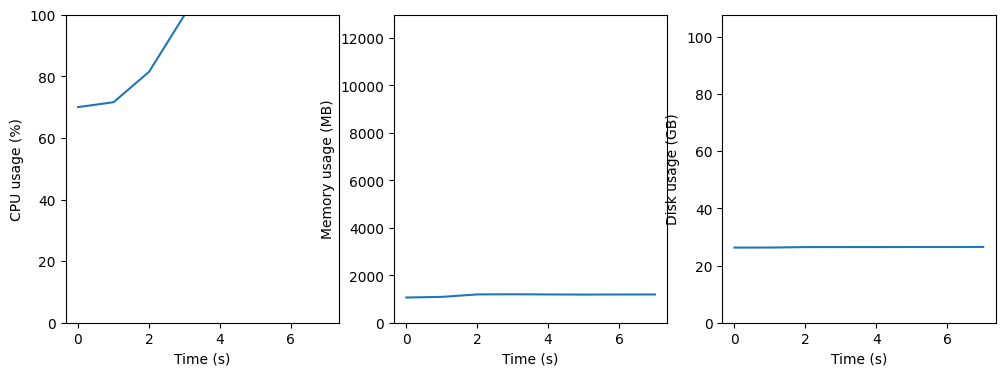

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  102.17 MB / 102.17 MB (100.89 MB/s) 1.2s (194/194)
Done in 1.42316 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 194 DICOM file(s)
Convert 194 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100148350742920339334061834697/1.3.6.1.4.1.14519.5.2.1.7009.9004.100148350742920339334061834697_2,OPA,TO,AQUL4,FC10,400,2,120,40,na,na_20010102000000_3 (512x512x194x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100148350742920339334061834697/1.3.6.1.4.1.14519.5.2.1.7009.9004.100148350742920339334061834697_2,OPA,TO,AQUL4,FC10,400,2,120,40,na,na_20010102000000_3.nii"
Conversion required 4.943184 seconds (0.430373 for core code).



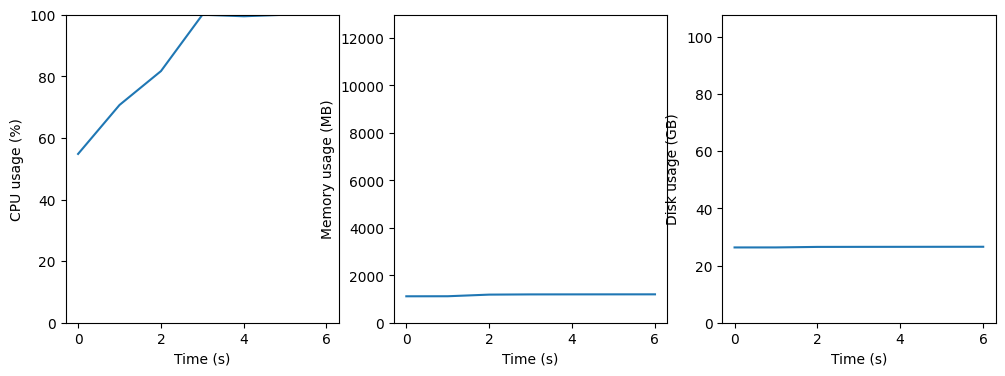

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  94.26 MB / 94.26 MB (58.67 MB/s) 1.8s (179/179)
Done in 2.04159 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 179 DICOM file(s)
Convert 179 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100241427395754063917290539621/1.3.6.1.4.1.14519.5.2.1.7009.9004.100241427395754063917290539621_0,OPA,TO,AQUL4,FC10,377,2,120,60,na,na_19990102000000_3 (512x512x179x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100241427395754063917290539621/1.3.6.1.4.1.14519.5.2.1.7009.9004.100241427395754063917290539621_0,OPA,TO,AQUL4,FC10,377,2,120,60,na,na_19990102000000_3.nii"
Conversion required 5.747788 seconds (0.462433 for core code).



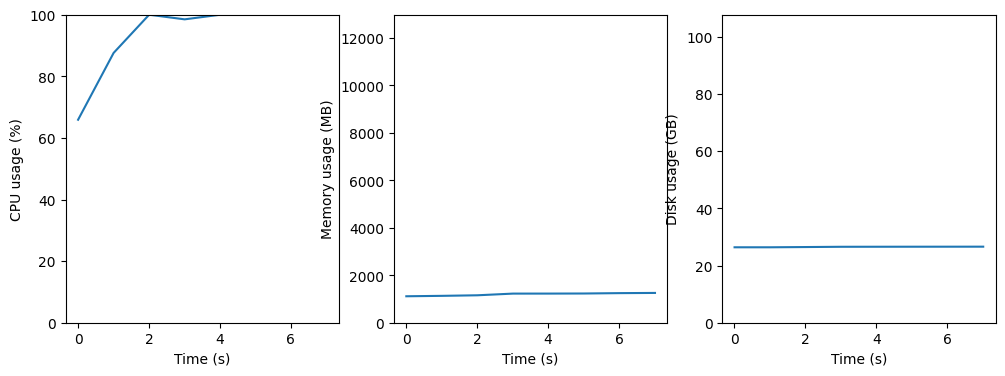

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  95.84 MB / 95.84 MB (106.30 MB/s) 1.1s (182/182)
Done in 1.32296 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 182 DICOM file(s)
Convert 182 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100266844261017577841946689119/1.3.6.1.4.1.14519.5.2.1.7009.9004.100266844261017577841946689119_0,OPA,TO,AQUL4,FC10,419.9,2,120,80,na,na_19990102000000_3 (512x512x182x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100266844261017577841946689119/1.3.6.1.4.1.14519.5.2.1.7009.9004.100266844261017577841946689119_0,OPA,TO,AQUL4,FC10,419.9,2,120,80,na,na_19990102000000_3.nii"
Conversion required 6.217399 seconds (0.380837 for core code).



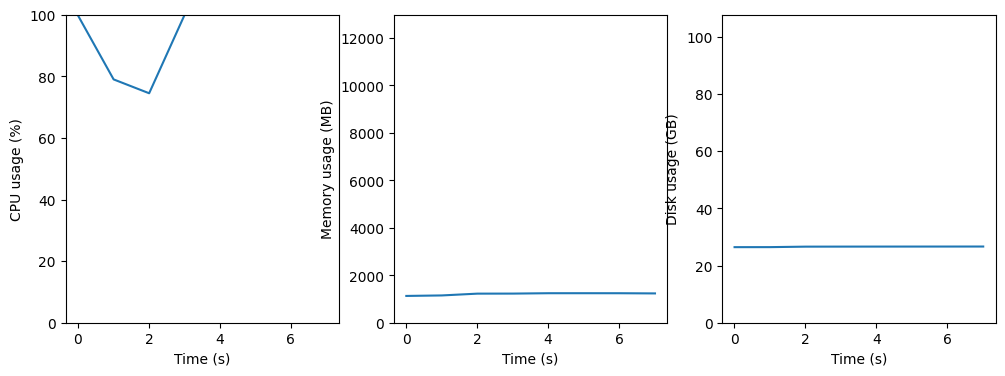

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  103.74 MB / 103.74 MB (101.28 MB/s) 1.2s (197/197)
Done in 1.42764 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 197 DICOM file(s)
Convert 197 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100554983367710060268444607770/1.3.6.1.4.1.14519.5.2.1.7009.9004.100554983367710060268444607770_2,OPA,TO,AQUL4,FC10,339.8,2,120,60,na,na_20010102000000_3 (512x512x197x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100554983367710060268444607770/1.3.6.1.4.1.14519.5.2.1.7009.9004.100554983367710060268444607770_2,OPA,TO,AQUL4,FC10,339.8,2,120,60,na,na_20010102000000_3.nii"
Conversion required 5.212727 seconds (0.430368 for core code).



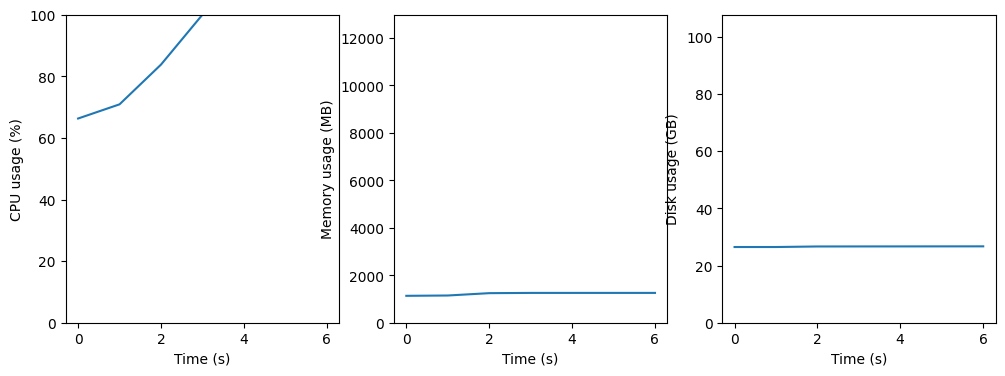

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  99.00 MB / 99.00 MB (74.66 MB/s) 1.5s (188/188)
Done in 1.72502 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 188 DICOM file(s)
Convert 188 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100609092457306482866656779396/1.3.6.1.4.1.14519.5.2.1.7009.9004.100609092457306482866656779396_1,OPA,TO,AQUL4,FC10,419.9,2,120,80,na,na_20000102000000_3 (512x512x188x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100609092457306482866656779396/1.3.6.1.4.1.14519.5.2.1.7009.9004.100609092457306482866656779396_1,OPA,TO,AQUL4,FC10,419.9,2,120,80,na,na_20000102000000_3.nii"
Conversion required 5.648005 seconds (0.468025 for core code).



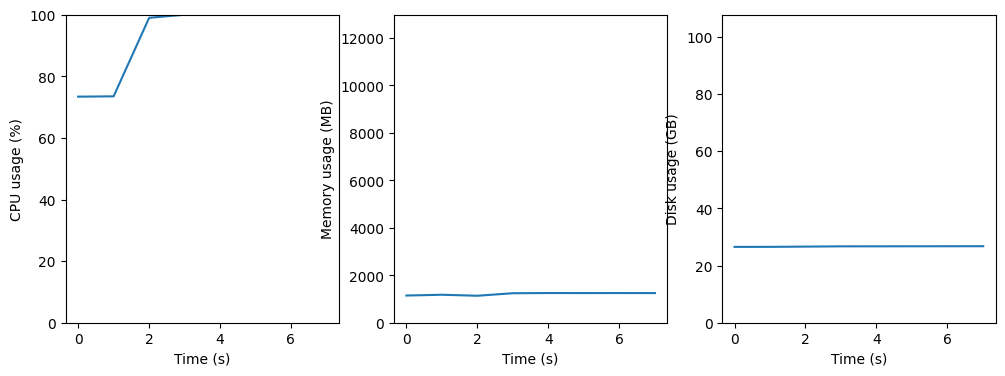

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100.58 MB / 100.58 MB (109.65 MB/s) 1.1s (191/191)
Done in 1.32199 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 191 DICOM file(s)
Convert 191 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100766949446324115207263771273/1.3.6.1.4.1.14519.5.2.1.7009.9004.100766949446324115207263771273_2,OPA,TO,AQUL4,FC51,371.1,2,120,60,na,na_20010102000000_4 (512x512x191x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100766949446324115207263771273/1.3.6.1.4.1.14519.5.2.1.7009.9004.100766949446324115207263771273_2,OPA,TO,AQUL4,FC51,371.1,2,120,60,na,na_20010102000000_4.nii"
Conversion required 4.669268 seconds (0.417005 for core code).



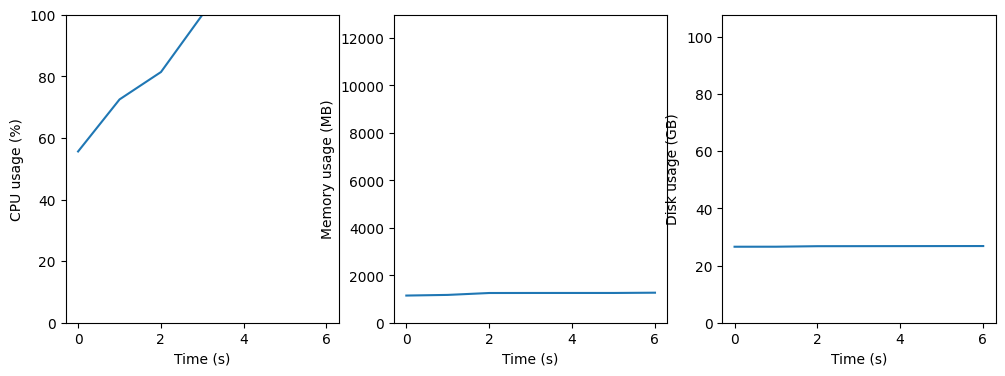

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  92.15 MB / 92.15 MB (109.21 MB/s) 1.0s (175/175)
Done in 1.21704 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 175 DICOM file(s)
Convert 175 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100807683971079396484581858934/1.3.6.1.4.1.14519.5.2.1.7009.9004.100807683971079396484581858934_1,OPA,TO,AQUL4,FC51,320.3,2,120,50,na,na_20000102000000_4 (512x512x175x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100807683971079396484581858934/1.3.6.1.4.1.14519.5.2.1.7009.9004.100807683971079396484581858934_1,OPA,TO,AQUL4,FC51,320.3,2,120,50,na,na_20000102000000_4.nii"
Conversion required 4.245894 seconds (0.377249 for core code).



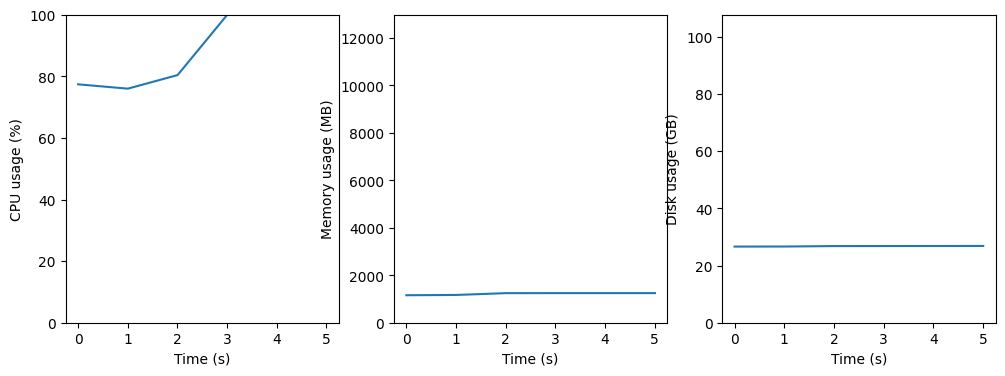

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  104.80 MB / 104.80 MB (109.16 MB/s) 1.2s (199/199)
Done in 1.42036 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 199 DICOM file(s)
Convert 199 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100898243941555041874482639283/1.3.6.1.4.1.14519.5.2.1.7009.9004.100898243941555041874482639283_2,OPA,TO,AQUL4,FC51,340.6,2,120,40,na,na_20010102000000_4 (512x512x199x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100898243941555041874482639283/1.3.6.1.4.1.14519.5.2.1.7009.9004.100898243941555041874482639283_2,OPA,TO,AQUL4,FC51,340.6,2,120,40,na,na_20010102000000_4.nii"
Conversion required 5.911508 seconds (0.336056 for core code).



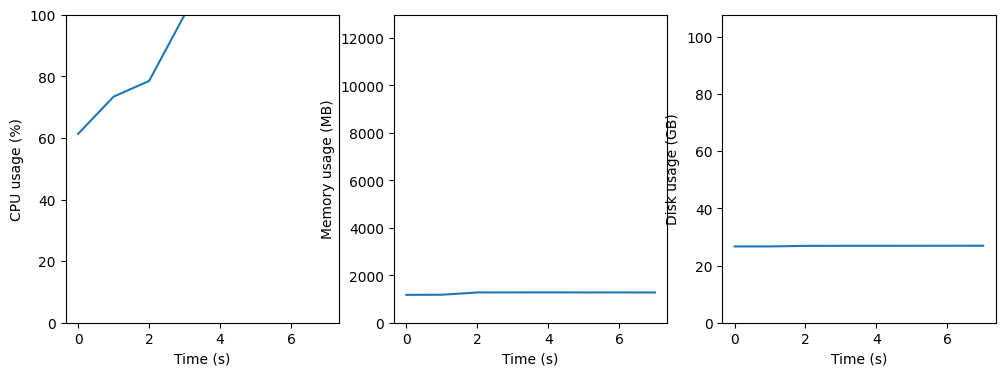

Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  93.21 MB / 93.21 MB (110.20 MB/s) 1.0s (177/177)
Done in 1.32742 seconds.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 177 DICOM file(s)
Convert 177 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100962349324934756610763981593/1.3.6.1.4.1.14519.5.2.1.7009.9004.100962349324934756610763981593_0,OPA,TO,AQUL4,FC51,369.1,2,120,40,na,na_19990102000000_5 (512x512x177x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100962349324934756610763981593/1.3.6.1.4.1.14519.5.2.1.7009.9004.100962349324934756610763981593_0,OPA,TO,AQUL4,FC51,369.1,2,120,40,na,na_19990102000000_5.nii"
Conversion required 4.352824 seconds (0.388308 for core code).



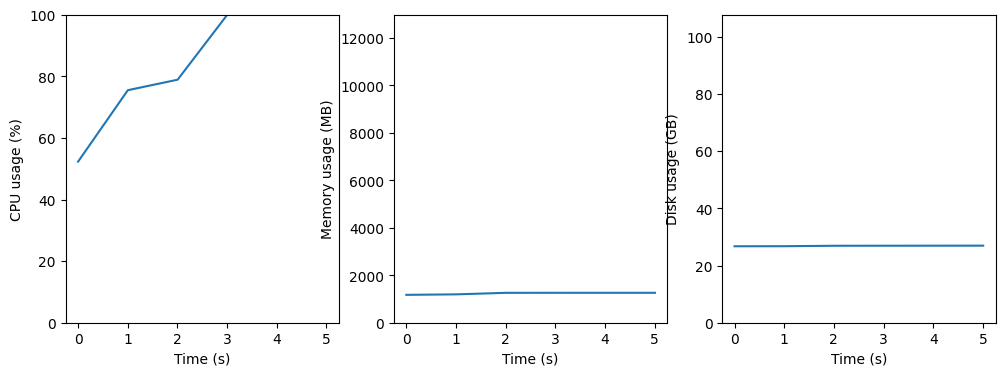

In [14]:
# Initialize a DataFrame to store runtime statistics
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','download_time',
                                      'NiftiConverter_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 'disk_usage_all', 'disk_total'
                                      ])

# Main execution
if __name__ == "__main__":
    # Loop over all series IDs
    for series_id in SeriesInstanceUIDs:
        # Create a ThreadPoolExecutor
        with ThreadPoolExecutor() as executor:
            # Initialize a MemoryMonitor instance
            monitor = MemoryMonitor()
            # Start a new thread to measure memory usage
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                # Start a new thread to download and process the series
                proc_thread = executor.submit(download_and_process_series, series_id)
                # Wait for the processing thread to finish
                proc_thread.result()
            finally:
                # Stop the memory monitor thread
                monitor.keep_measuring = False
                # Get the results from the memory monitor thread
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()

                # Update the runtime statistics DataFrame with the results
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]

                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                # Update total disk space for all rows (assuming it's the same for all series)
                runtime_stats['disk_total']=disk_total

                # Plot CPU usage, memory usage and disk usage over time
                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4))

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')

                plt.show()


###**Monitoring for dcm2niix Errors**

In [15]:
def check_dcm2niix_errors(path: str) -> None:
    """
    Check for errors in the conversion of DICOM to NIfTI files.

    Args:
    path: The path to the directory containing the series directories.
    """
    # Loop over all series directories in the path
    for series_id in os.listdir(path):
        series_id_path = os.path.join(path, series_id)

        # Check if the path is a directory
        if os.path.isdir(series_id_path):
            # Count the number of files in the directory
            num_files = len([f for f in os.listdir(series_id_path) if os.path.isfile(os.path.join(series_id_path, f))])

            # If no files or more than one file found, log an error and remove the directory
            if num_files == 0 or num_files > 1:
                print(f'{"No" if num_files == 0 else "More than one"} NIfTI file{"s" if num_files > 1 else ""} found for {series_id}')

                with open('dcm2niix_errors.csv', 'a') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([series_id])

                shutil.rmtree(os.path.join('dcm2niix', series_id))


In [16]:
# Check if the converter type is 'dcm2niix'
if converterType.lower()=='dcm2niix':
    # If it is, call the function to check for errors in the 'dcm2niix' directory
    check_dcm2niix_errors(f'/{curr_dir}/dcm2niix')


###**Compressing Output Files**


In [17]:
# Attempt to remove the archive file if it exists
try:
  os.remove('downloadDicomAndConvertNiftiFiles.tar.lz4')
except OSError:
  pass

# Record the start time of the archiving process
start_time = time.time()

# Create a tar archive of the converterType directory, compress it with lz4, and save it as downloadDicomAndConvertNiftiFiles.tar.lz4
!tar cvf - -C {curr_dir} {converterType} | lz4 > downloadDicomAndConvertNiftiFiles.tar.lz4

# Calculate and record the time taken for the archiving process
archiving_time = time.time() - start_time


dcm2niix/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100766949446324115207263771273/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100766949446324115207263771273/1.3.6.1.4.1.14519.5.2.1.7009.9004.100766949446324115207263771273_2,OPA,TO,AQUL4,FC51,371.1,2,120,60,na,na_20010102000000_4.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100554983367710060268444607770/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100554983367710060268444607770/1.3.6.1.4.1.14519.5.2.1.7009.9004.100554983367710060268444607770_2,OPA,TO,AQUL4,FC10,339.8,2,120,60,na,na_20010102000000_3.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100609092457306482866656779396/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100609092457306482866656779396/1.3.6.1.4.1.14519.5.2.1.7009.9004.100609092457306482866656779396_1,OPA,TO,AQUL4,FC10,419.9,2,120,80,na,na_20000102000000_3.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.

###Utilization Metrics

In [18]:
# Save the runtime statistics DataFrame to a CSV file
runtime_stats.to_csv('runtime.csv')

# Add the csv_read_time and archiving_time to the DataFrame as new columns
runtime_stats['csv_read_time'] = read_time
runtime_stats['archiving_time'] = archiving_time

# Attempt to remove the lz4 file if it exists
try:
  os.remove('downloadDicomAndConvertUsageMetrics.lz4')
except OSError:
  pass

# Compress the runtime.csv file using lz4 and save it as downloadDicomAndConvertUsageMetrics.lz4
!lz4 {curr_dir}/runtime.csv downloadDicomAndConvertUsageMetrics.lz4

# Print the runtime statistics DataFrame
runtime_stats


Compressed 4604 bytes into 2924 bytes ==> 63.51%


,SeriesInstanceUID,download_time,NiftiConverter_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total,csv_read_time,archiving_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999...,1.433753,6.071829,"[[[70.0, 71.6, 81.5, 100.0, 100.0, 100.0, 100....","[[[1062.45703125, 1089.28515625, 1192.69140625...",[12982.625],"[[[26.28262710571289, 26.286178588867188, 26.4...",107.715084,0.014052,2.055217
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.100148350742...,1.534803,4.979058,"[[[54.8, 70.7, 81.7, 100.0, 99.5, 100.0, 100.0]]]","[[[1113.95703125, 1116.0390625, 1184.53125, 11...",[12982.625],"[[[26.327747344970703, 26.333236694335938, 26....",107.715084,0.014052,2.055217
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.100241427395...,2.153718,5.825007,"[[[65.9, 87.6, 100.0, 98.5, 100.0, 100.0, 100....","[[[1115.15625, 1132.8671875, 1156.3984375, 122...",[12982.625],"[[[26.37950897216797, 26.380016326904297, 26.4...",107.715084,0.014052,2.055217
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.100266844261...,1.442780,6.249543,"[[[99.7, 79.0, 74.5, 100.0, 100.0, 100.0, 100....","[[[1129.16796875, 1150.11328125, 1225.8203125,...",[12982.625],"[[[26.426593780517578, 26.436946868896484, 26....",107.715084,0.014052,2.055217
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.100554983367...,1.540174,5.244725,"[[[66.3, 70.9, 83.8, 100.0, 100.0, 100.0, 100....","[[[1134.05078125, 1147.375, 1246.08203125, 125...",[12982.625],"[[[26.474197387695312, 26.475067138671875, 26....",107.715084,0.014052,2.055217
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.100609092457...,1.833831,5.680484,"[[[73.4, 73.5, 99.0, 100.0, 100.0, 100.0, 100....","[[[1145.49609375, 1179.41015625, 1136.8125, 12...",[12982.625],"[[[26.52526092529297, 26.530853271484375, 26.6...",107.715084,0.014052,2.055217
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.100766949446...,1.431442,4.717477,"[[[55.6, 72.5, 81.4, 100.0, 100.0, 100.0, 100....","[[[1145.0234375, 1172.55078125, 1252.63671875,...",[12982.625],"[[[26.574928283691406, 26.584362030029297, 26....",107.715084,0.014052,2.055217
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.100807683971...,1.325914,4.280384,"[[[77.4, 76.0, 80.4, 100.0, 100.0, 100.0]]]","[[[1158.2578125, 1170.8203125, 1246.421875, 12...",[12982.625],"[[[26.630523681640625, 26.647903442382812, 26....",107.715084,0.014052,2.055217
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.100898243941...,1.531731,5.947079,"[[[61.3, 73.4, 78.5, 100.0, 100.0, 100.0, 100....","[[[1174.94921875, 1180.3515625, 1275.9140625, ...",[12982.625],"[[[26.680442810058594, 26.683975219726562, 26....",107.715084,0.014052,2.055217
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.100962349324...,1.438954,4.390545,"[[[52.3, 75.5, 78.9, 100.0, 100.0, 100.0]]]","[[[1174.7265625, 1195.79296875, 1260.1875, 126...",[12982.625],"[[[26.739013671875, 26.76154327392578, 26.9131...",107.715084,0.014052,2.055217
